In [3]:
%load_ext autoreload
%autoreload 2

import xarray as xr
import spatialproteomics as sp
import matplotlib.pyplot as plt
import tifffile
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import StandardScaler
import matplotlib as mpl
from glob import glob
from tqdm.auto import tqdm
from adjustText import adjust_text
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os
from scipy.interpolate import interp1d
from sklearn.metrics import auc
import scanpy as sc


# Load the custom style from your .ini file
mpl.style.core.use('pub_matplotlib_rc.ini')

entity_colors = {'LN': '#9dcbec', # light blue
                 'CLL': '#FAD0CE', 'LPL': '#EEBFBD', 'MZL': '#E2AFAC', 
                 'FL 1': '#D59E9C', 'FL 2': '#C98D8B', 'FL 3a': '#BD7C7A', 'FL 3b': '#B16C69', 
                 'MCL': '#A55B58', 'DLBCL': '#994A47', 'PMBCL': '#8C3937', 'Burkitt': '#802926', 'BLBL': '#741815'}

entity_class_colors = {'LN': '#9dcbec', 'indolent': '#E2AFAC', 'aggressive': '#741815'}

# red, blue, green, yellow, purple, teal (from the nature color palette: https://www.nature.com/documents/natrev-artworkguide.pdf) 
celltype_colors = {'B cell': '#5799d1', 'T cell': '#ebc850', 'Myeloid cell': '#de6866', 'Dendritic cell': '#4cbcbd', 'Macrophage': '#bb7cb4', 'Stromal cell': '#62b346', 'Endothelial cell': '#bf997d'}

nh_mapping_dict = {'Neighborhood 0': 'T/Dendritic',
                      'Neighborhood 1': 'T',
                      'Neighborhood 2': 'Mixed',
                      'Neighborhood 3': 'B_prol/T_fh',
                      'Neighborhood 4': 'T_h/T_reg',
                      'Neighborhood 5': 'B',
                      'Neighborhood 6': 'Myeloid/Macro'}

entity_grouping_dict = {'LN': 'LN', 'FL 1': 'indolent', 'FL 2': 'indolent', 'FL 3a': 'indolent', 'FL 3b': 'indolent', 'MZL': 'indolent', 'DLBCL': 'aggressive', 'Burkitt': 'aggressive', 'PMBCL': 'aggressive', 'DLBCL': 'aggressive', 'BLBL': 'aggressive'}


# colors for neighborhoods
neighborhood_colors = {'B': '#5799d1',
                       'B_prol/T_fh': '#154e91',
                       'T/Dendritic': '#fef1c3',
                       'T': '#ebc850',
                       'T_h/T_reg': '#cca02d',
                       'Myeloid/Macro': '#de6866',
                       'Mixed': '#c8ceda'}

metadata = pd.read_csv("2025-01-28_bnhl_metadata.csv", index_col=0)
files = glob("/g/huber/users/meyerben/data/codex/BNHL/zarrs_with_neighborhoods/*")

all_cts = ['B cell', 'B_prol', 'T cell', 'T_h', 'T_h_mem', 'T_h_naive', 'T_reg', 'T_fh', 'T_reg_Helios', 'T_tox', 'T_exh', 'T_progenitor_exh', 'T_terminally_exh', 'T_tox_naive', 'T_tox_mem', 'Myeloid cell', 'Dendritic cell', 'Macrophage', 'M2', 'Stromal cell', 'Endothelial cell']
# all_nhs = [f'Neighborhood {i}' for i in range(7)]
all_nhs = list(neighborhood_colors.keys())

# for this figure, I want to sort by entity and B cell content, but also keep replicates next to one another
# adding the celltype abundances which have been precomputed in the snakemake pipeline
abundance_df = pd.read_csv("/g/huber/users/meyerben/data/codex/BNHL/ct_abundances/ct_abundances_level_0.csv", index_col=0)
# normalizing the cell type abundances per sample
# normalizing per sample so that each sample sums up to one
abundance_df = abundance_df.div(abundance_df.sum(axis=1), axis=0)
# merging with the metadata
df = pd.merge(metadata, abundance_df, left_on='Histo-Nr', right_index=True)

# Convert 'entity' column to a categorical type with the custom order
df['Entity'] = pd.Categorical(df['Entity'], categories=entity_colors.keys(), ordered=True)
df = df.sort_values(by=['Entity', 'B cell'])

# === reading the zarrs into the sample dict ===
sample_dict = {}
sample_to_patient_dict = {}
for i, (sample_id_a, sample_id_b, patient_id) in tqdm(df[["sample_id_a", "sample_id_b", "Histo-Nr"]].iterrows()):
    # adding sample a and b to the dictionary if we have images for them
    for sample_id in [sample_id_a, sample_id_b]:
        if pd.isna(sample_id):
            continue
        sample_to_patient_dict[sample_id] = patient_id
        file_mask = [f"{sample_id}.zarr" in x for x in files]
        # print(files)
        # file_mask = [sample_id == x for x in files]
        matching_files = [files[i] for i, mask in enumerate(file_mask) if mask]
        if len(matching_files) != 1:
            raise ValueError(f"Matching files for sample {sample_id}: {matching_files}")
        else:
            file = matching_files[0]
            # ds = xr.open_zarr(file)
            # also renaming the neighborhoods here
            # nh_mapping_dict_tmp  = {k: v for k, v in nh_mapping_dict.items() if k in ds.pp.get_layer_as_df()['_neighborhoods'].unique()}
            # this is slowing things down quite a bit, should probably do this in the pipeline directly
            sample_dict[sample_id] = xr.open_zarr(file) # .nh.set_neighborhood_name(nh_mapping_dict_tmp.keys(), nh_mapping_dict_tmp.values()).nh.set_neighborhood_colors(neighborhood_colors.keys(), neighborhood_colors.values())
            
patient_to_entity_mapping = dict(zip(df['Histo-Nr'].values, df['Entity'].values))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


0it [00:00, ?it/s]

In [4]:
len(sample_dict)

250

In [5]:
num_cells = 0
num_samples = 0
for sample_id, ds in sample_dict.items():
    num_cells += ds.sizes['cells']
    num_samples += 1

In [6]:
num_cells / num_samples

14273.516

In [7]:
num_cells

3568379

In [8]:
adata = sc.read_h5ad(f"/g/huber/users/meyerben/data/codex/BNHL/anndata/all_samples.h5ad")
adata

/home/meyerben/meyerben/.conda/envs/tmp_env_2/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 3568379 × 56
    obs: 'BCL-2_binarized', 'BCL-6_binarized', 'CD163_binarized', 'CD45RA_binarized', 'CD45RO_binarized', 'CD8_binarized', 'DAPI_binarized', 'FOXP3_binarized', 'Helios_binarized', 'ICOS_binarized', 'Ki-67_binarized', 'PD-1_binarized', 'TCF7-TCF1_binarized', 'Tim3_binarized', '_labels', 'centroid-0', 'centroid-1', 'labels_0', 'labels_1', 'labels_2', 'labels_3', 'sample_id', 'Histo-Nr', 'Entity', 'Sex', 'Age', 'Pre-treatment_Category', 'Pre-treatment_binary', 'Date_of_Sample_Extraction', 'Entity_Class', 'LAG3_binarized', 'SPARC_binarized'
    obsm: 'spatial'

In [9]:
abundance_df

,B cell,T cell,Myeloid cell,Dendritic cell,Macrophage,Stromal cell,Endothelial cell
E-2011-012797,0.384437,0.462186,0.060184,0.000331,0.045403,0.011401,0.036058
E-2009-041128,0.851788,0.044375,0.035156,0.000233,0.010291,0.024399,0.033759
E-2009-002389,0.721340,0.156570,0.047313,0.001931,0.035920,0.022678,0.014248
E-2008-031052,0.362392,0.332182,0.211154,0.005087,0.015702,0.044404,0.029079
E-2013-023696,0.767068,0.038734,0.012336,0.092678,0.060577,0.019102,0.009507
...,...,...,...,...,...,...,...
E-2015-002425,0.386933,0.465831,0.057864,0.073146,0.004550,0.000515,0.011161
E-2013-014622,0.236718,0.557102,0.028991,0.139526,0.017012,0.002123,0.018529
R-2012-000567,0.252329,0.227164,0.215460,0.055352,0.158791,0.062082,0.028822
R-2009-000021,0.625789,0.229919,0.028778,0.007068,0.075377,0.020700,0.012369


# PCA

In [36]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# --- Assume abundance_df is already loaded ---
# For example, abundance_df might have columns:
# ['entity_class', 'sample', 'B_cell', 'T_cell', 'NK_cell', 'Monocyte', 'Dendritic', ...]
# Let’s assume that the only non-abundance columns are "entity_class" and "sample".
abundance_cols = [col for col in abundance_df.columns if col not in ['entity_class', 'sample']]

# Extract the abundance features and convert to a NumPy array.
X = abundance_df[abundance_cols].values

# Center and scale the features.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Run PCA to get the first 2 principal components.
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

# Create a DataFrame with PCA results.
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df.index = abundance_df.index

pca_df = pca_df.merge(metadata, left_index=True, right_on='Histo-Nr', how='left')
pca_df.index = abundance_df.index

pca_df = pd.concat([pca_df, abundance_df], axis=1)

/tmp/ipykernel_918/1969874551.py:40: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles, labels = legend.legendHandles, [t.get_text() for t in legend.get_texts()]


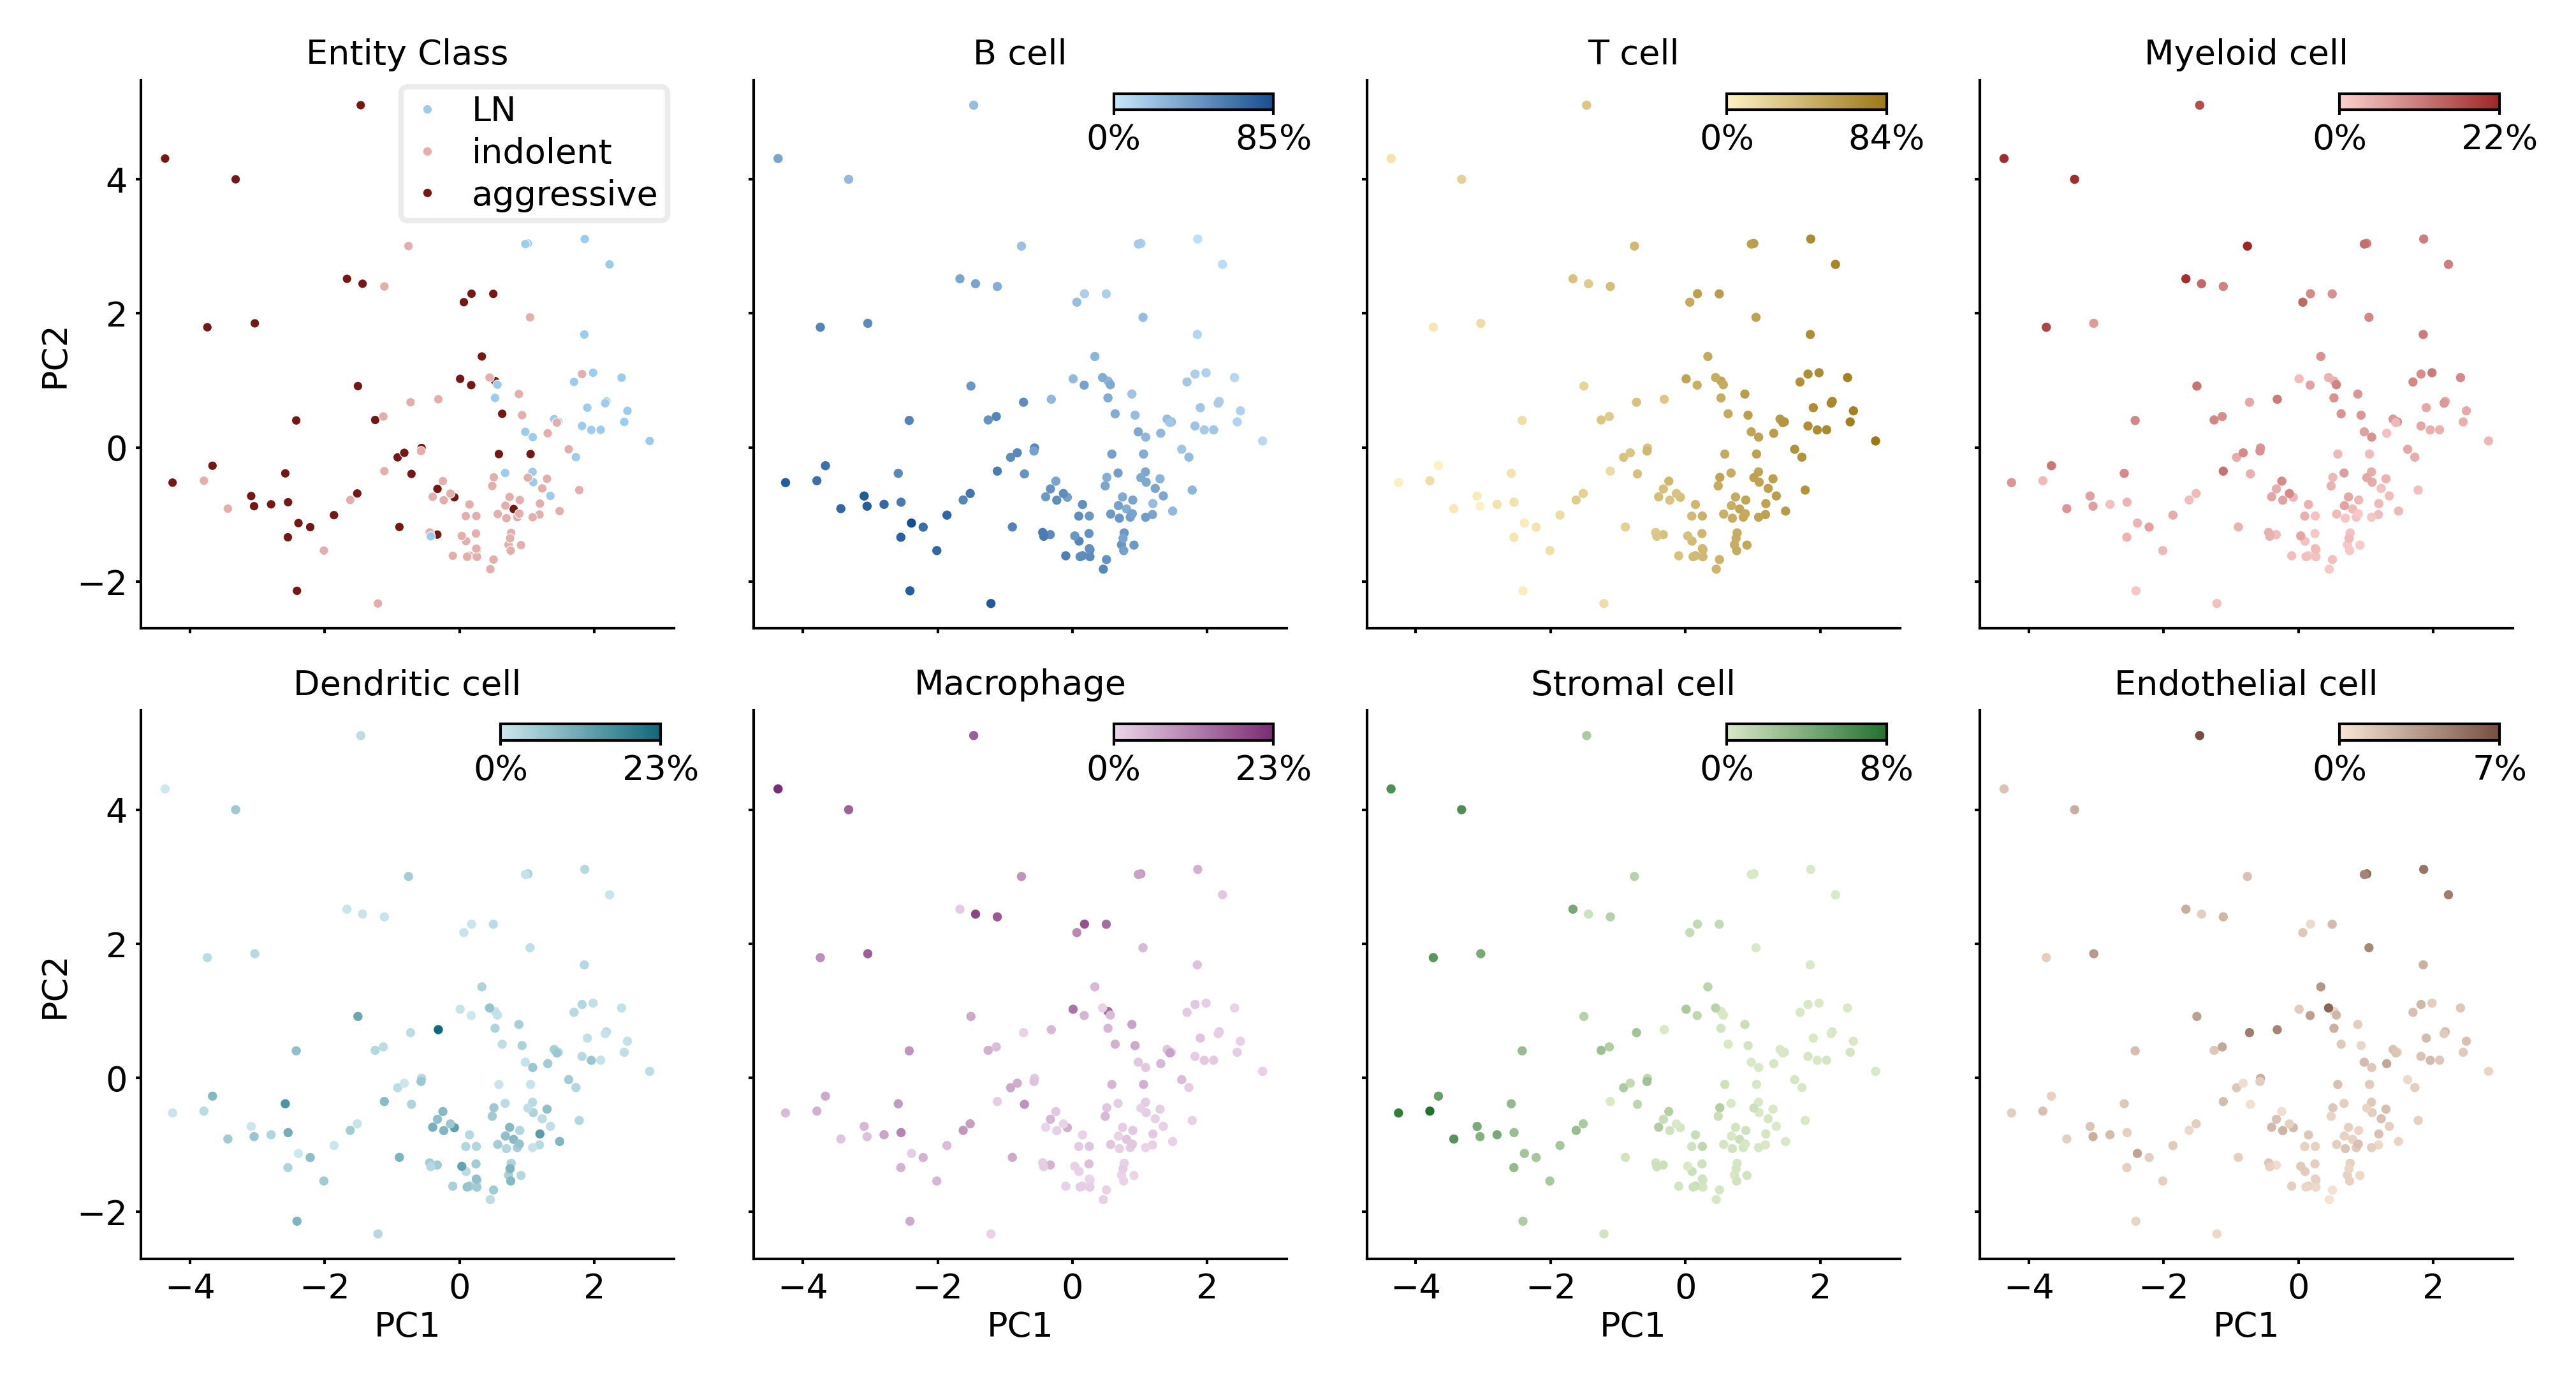

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Define styling variables
font_size = 6.5
point_size = 3
spacing = 0.15

# Custom colormaps for each cell type
abundance_colormap = {
    "B cell": mcolors.LinearSegmentedColormap.from_list("B_cell_cmap", ["#c8e7fb", "#154e91"]),
    "T cell": mcolors.LinearSegmentedColormap.from_list("T_cell_cmap", ["#fef1c3", "#9c7817"]),
    "Myeloid cell": mcolors.LinearSegmentedColormap.from_list("Myeloid_cell_cmap", ["#fad0ce", "#9c2726"]),
    "Dendritic cell": mcolors.LinearSegmentedColormap.from_list("Dendritic_cell_cmap", ["#cce7ed", "#106879"]),
    "Macrophage": mcolors.LinearSegmentedColormap.from_list("Macrophage_cmap", ["#ebd6e9", "#792c73"]),
    "Stromal cell": mcolors.LinearSegmentedColormap.from_list("Stromal_cell_cmap", ["#d9e8c6", "#237130"]),
    "Endothelial cell": mcolors.LinearSegmentedColormap.from_list("Endothelial_cell_cmap", ["#f8e6d7", "#754f40"]),
}

# Create a 2x4 grid for subplots (8 subplots total) with a figure size of 8x4 inches.
fig, axes = plt.subplots(2, 4, figsize=(8, 4), dpi=600, sharex=True, sharey=True)
axes = axes.flatten()

# Set spacing between plots
plt.subplots_adjust(wspace=spacing, hspace=spacing)

# Plot 1: PCA colored by entity_class
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Entity_Class', 
                palette=entity_class_colors, ax=axes[0], s=point_size)

axes[0].set_title('Entity Class', fontsize=font_size)

# Customize legend order and position
custom_order = ['LN', 'indolent', 'aggressive']
legend = axes[0].get_legend()
if legend:
    handles, labels = legend.legendHandles, [t.get_text() for t in legend.get_texts()]
    
    # Sort handles according to custom order
    handles_dict = dict(zip(labels, handles))
    sorted_handles = [handles_dict[label] for label in custom_order if label in handles_dict]

    axes[0].legend(sorted_handles, custom_order, title=None, fontsize=font_size,
                   loc='upper right', bbox_to_anchor=(1.02, 1.02), frameon=True)  # Move legend to top-right

# Plots 2-8: One plot per cell type abundance
for i, cell_type in enumerate(abundance_cols, start=1):
    min_val, max_val = pca_df[cell_type].min(), pca_df[cell_type].max()
    cmap = abundance_colormap.get(cell_type, plt.cm.viridis)  # Default to viridis if missing

    norm = mcolors.Normalize(vmin=0, vmax=max_val)  # Always start at 0
    sc = axes[i].scatter(pca_df['PC1'], pca_df['PC2'],
                         c=pca_df[cell_type], cmap=cmap, norm=norm,
                         s=point_size, edgecolor='none')

    axes[i].set_title(cell_type, fontsize=font_size)

    # Create inset axes for a horizontal colorbar inside the plot
    cax = inset_axes(axes[i], width="30%", height="3%", loc="upper right", borderpad=0.5)  # Adjust size and position for horizontal layout
    cbar = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=font_size)
    cbar.set_ticks([0, max_val])  # Show only the min and max values
    cbar.set_ticklabels([f'0%', f'{int(max_val * 100)}%'])

# Adjust axis labels
for i, ax in enumerate(axes):
    ax.tick_params(labelsize=font_size)
    
    # Only show y-axis labels for plots 0 and 4
    if i in [0, 4]:
        ax.set_ylabel('PC2', fontsize=font_size)
    else:
        ax.set_ylabel("")

    # Only show x-axis labels for plots 4-7
    if i in [4, 5, 6, 7]:
        ax.set_xlabel('PC1', fontsize=font_size)
    else:
        ax.set_xlabel("")

# Remove the top and right spines for all plots
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Hide any unused subplots
for j in range(i + 1, 8):
    axes[j].axis("off")

plt.savefig('figures/supp_fig_5/individual_panels/s5a.png', bbox_inches='tight', pad_inches=0)
plt.show()

/tmp/ipykernel_918/641533794.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=loadings_df, x='Cell Type', y='PC1', palette=celltype_colors, ax=axes[0])
/tmp/ipykernel_918/641533794.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=loadings_df, x='Cell Type', y='PC2', palette=celltype_colors, ax=axes[1])


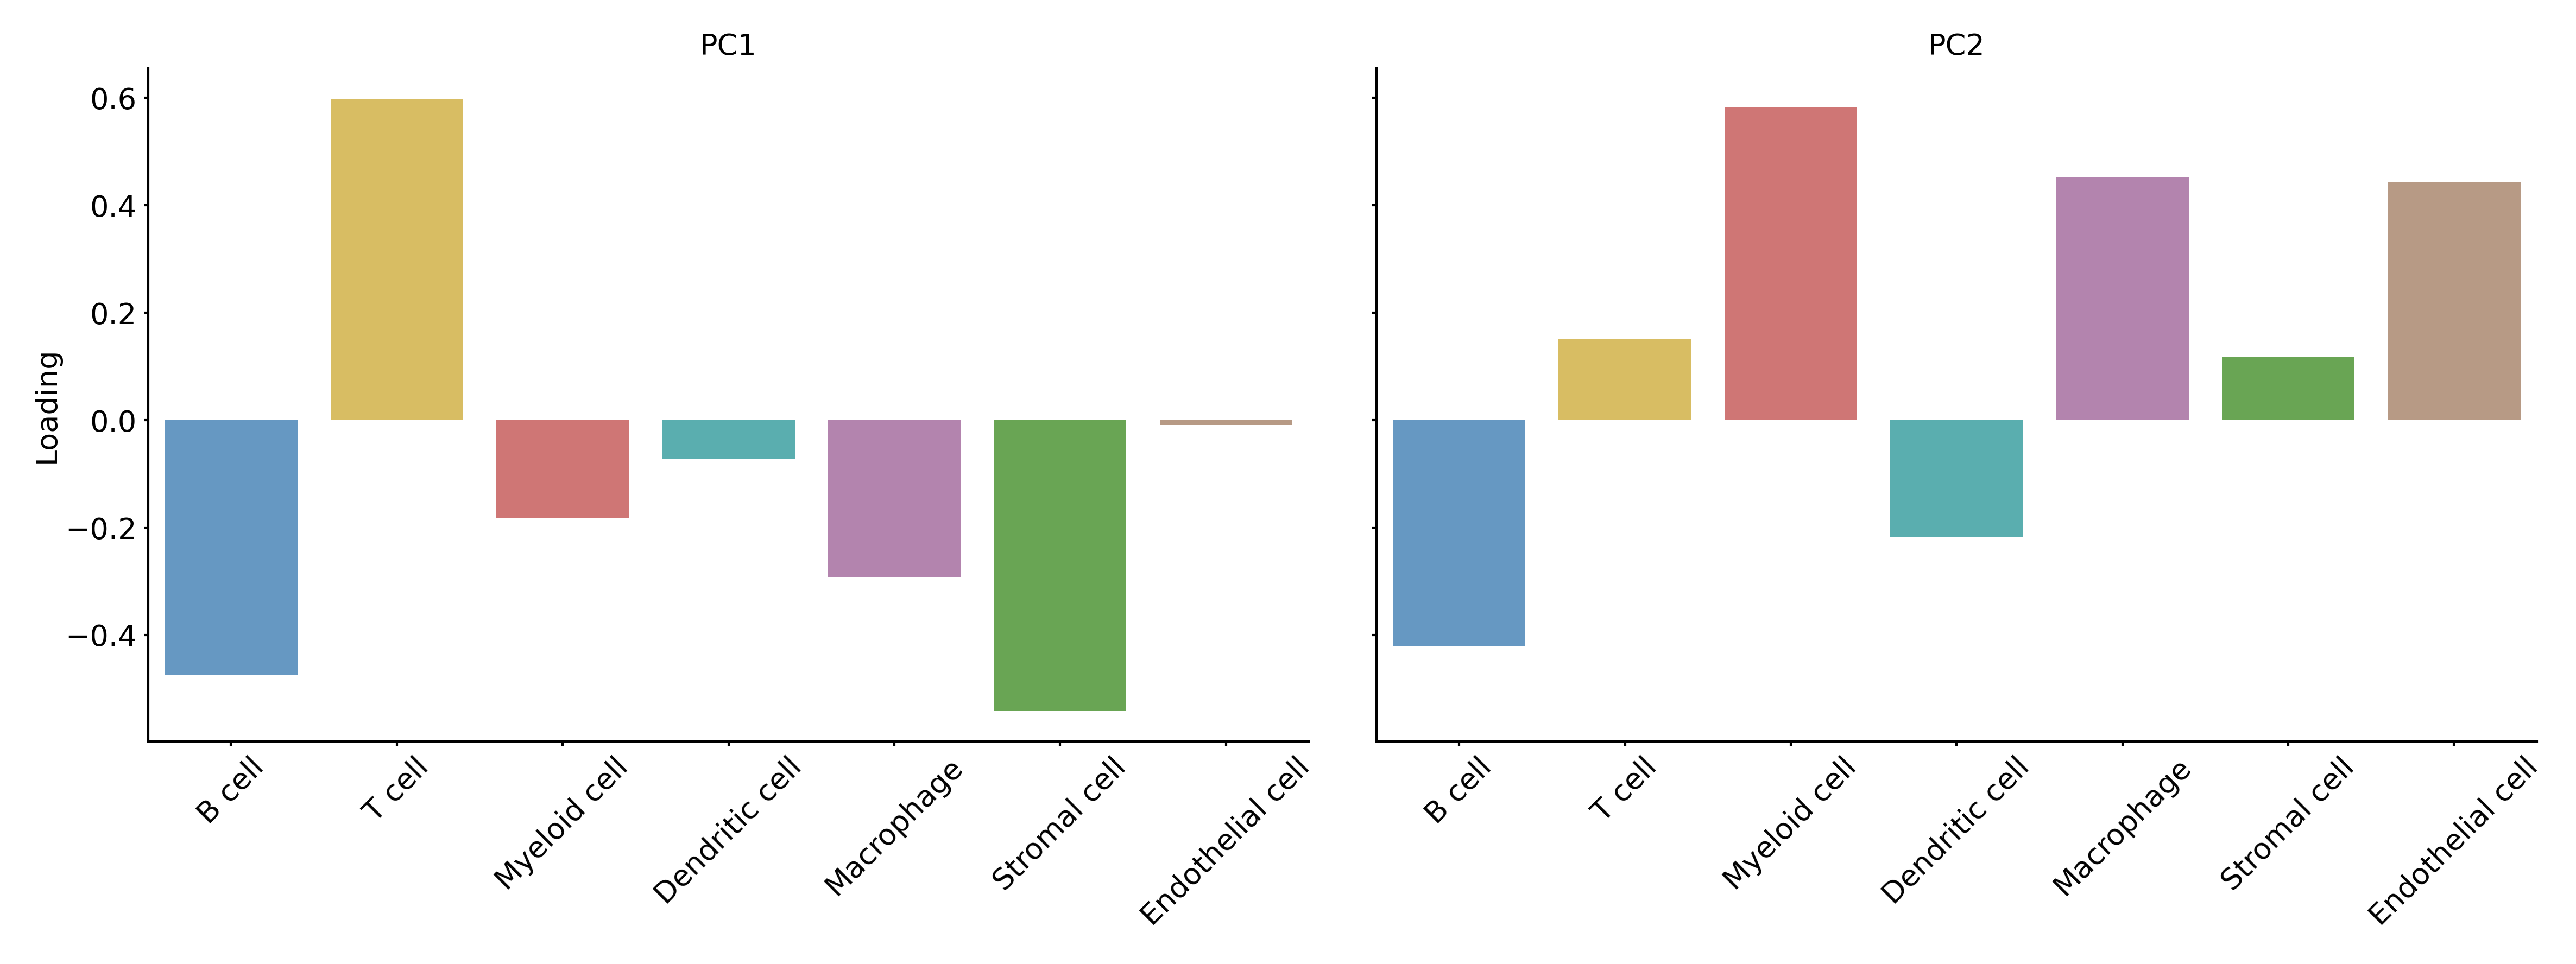

In [120]:
# Convert to DataFrame for easy plotting (if necessary)

# Get the PCA loadings (components)
loadings = pca.components_

# Create a DataFrame for loadings, with features as rows and components as columns
loadings_df = pd.DataFrame(loadings.T, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=abundance_cols)
loadings_df['Cell Type'] = loadings_df.index

# Create the plot
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=600, sharey=True)

# Plot PC1 loadings
sns.barplot(data=loadings_df, x='Cell Type', y='PC1', palette=celltype_colors, ax=axes[0])
axes[0].set_title("PC1", fontsize=font_size)
axes[0].set_xlabel("")
axes[0].set_ylabel("Loading", fontsize=font_size)
axes[0].tick_params(axis='both', labelsize=font_size)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].tick_params(axis='x', labelrotation=45)

# Plot PC2 loadings
sns.barplot(data=loadings_df, x='Cell Type', y='PC2', palette=celltype_colors, ax=axes[1])
axes[1].set_title("PC2", fontsize=font_size)
axes[1].set_xlabel("")
axes[1].set_ylabel("Loading", fontsize=font_size)
axes[1].tick_params(axis='both', labelsize=font_size)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].tick_params(axis='x', labelrotation=45)

# Adjust layout
plt.tight_layout()

# Show plot
plt.savefig('figures/supp_fig_5/individual_panels/s5b.svg', bbox_inches='tight', pad_inches=0)
plt.show()

In [107]:
loadings_df

,PC1,PC2
B cell,-0.475285,-0.420515
T cell,0.597784,0.151481
Myeloid cell,-0.183285,0.582167
Dendritic cell,-0.072790,-0.216966
Macrophage,-0.291643,0.452097
Stromal cell,-0.541037,0.117280
Endothelial cell,-0.009494,0.442811
